# University Campus Venue Analysis

## Week 1

### Problem description

This Capstone project will investigate the venues close to some university campuses, such as the MIT and Harvard campus in Cambridge, MA, the Columbia campus in Manhattan, NY, the NTNU campus in Trondheim, NO and the EPFL campus in Lausanne, CH. 

The universities are different in size and academic scope, and this should be reflected in the analysis. Although cultural differences may also influence the venues nearby campuses, this will be excluded from the analysis, under the assumption that all campuses have a diverse, international student body.

The goal of the project is to identify what universities have similar venues and cluster them in qualitatively reasonable clusters.

### Data description

The required data will be coordinates for the different campuses, which can be found manually on Google Maps, the venues nearby the cmapuses, found using the Foursquare API, the type of university, found using Wikipedia, and the size of the university (in terms of students), also found using Wikipedia. Additional universities, other than the ones mentioned above, may be included for a even more thorough analysis of university campuses.

The data will be used to extract reasonable features. The features will be encoded in such a way that the scaling problem is not an issue, e.g. using one-hot encoding for categorical variables, such as university type. The features will also be scaled to avoid improper weight on the different features. If this is not done, the size feature is likely to dominate the feature space, as it would likely have dominated being the scales of thousands, compared to the one-hot-encoded university type being either 0 or 1. After applying a clustering algorithm, for instance, kmeans, for different k. A k will be chosen based on the resulting clusters having the most reasonable qualitative description. Although a geographical visualization is possible, the geographical location is not actually assumed to be important, under the cultural assumption mentioned in the problem description, and using other visualization techniques, such as two- or three-dimensional scatter plots on features might be a better way to display the resulting clusters. 

## Week 2

### Data sourcing

In [98]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import json
import matplotlib.pyplot as plt

In [5]:
CLIENT_ID = 'ISK40HZPWZIWIGSFE1HDY4GWSNZVBCPNTU4S51H5FAWITVBN'
CLIENT_SECRET = 'VY2ALRX4L30WS03EFZGHXVRQODHQHJ5IRPEE2YMMPEAI04X2'
VERSION = '20180605'
LIMIT = 100

In [49]:
df = pd.DataFrame({'Campus': ['Harvard', 'MIT', 'Columbia', 'NTNU', 'EPFL'],
                   'City': ['Cambridge', 'Cambridge', 'New York', 'Trondheim', 'Lausanne'],
                   'State': ['Massachusetts', 'Massachusetts', 'New York', 'Norway', 'Switzerland'],
                  'Number of students': [20970, 11520, 31317, 41971, 11449],
                   'University type': ['University', 'Technical institute', 'University', 'University', 'Technical institute'],
                   'Latitude': [42.374443, 42.358492, 40.807537, 63.419525, 46.518653],
                   'Longitude': [-71.116943, -71.091346, -73.962570, 10.401346, 6.566613]
                  })
df

,Campus,City,State,Number of students,University type,Latitude,Longitude
0,Harvard,Cambridge,Massachusetts,20970,University,42.374443,-71.116943
1,MIT,Cambridge,Massachusetts,11520,Technical institute,42.358492,-71.091346
2,Columbia,New York,New York,31317,University,40.807537,-73.962570
3,NTNU,Trondheim,Norway,41971,University,63.419525,10.401346
4,EPFL,Lausanne,Switzerland,11449,Technical institute,46.518653,6.566613


In [64]:
def get_nearby_venues(names, latitudes, longitudes, radius=500):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Campus', 
                  'Campus Latitude', 
                  'Campus Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

venues = get_nearby_venues(df['Campus'], df['Latitude'], df['Longitude'])
venues

,Campus,Campus Latitude,Campus Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harvard,42.374443,-71.116943,Harvard Square,42.373458,-71.119004,Plaza
1,Harvard,42.374443,-71.116943,Tatte Bakery & Cafe,42.372795,-71.116966,Café
2,Harvard,42.374443,-71.116943,Harvard Book Store,42.372580,-71.116421,Bookstore
3,Harvard,42.374443,-71.116943,Harvard Art Museums,42.374206,-71.114368,Art Museum
4,Harvard,42.374443,-71.116943,Clover HSQ,42.373023,-71.117950,Vegetarian / Vegan Restaurant
...,...,...,...,...,...,...,...
187,EPFL,46.518653,6.566613,Musée Bolo,46.518708,6.563703,Science Museum
188,EPFL,46.518653,6.566613,Le Négoce,46.520559,6.568279,Deli / Bodega
189,EPFL,46.518653,6.566613,Métro EPFL (m1),46.522200,6.566104,Light Rail Station
190,EPFL,46.518653,6.566613,Fée d'Or,46.520568,6.561455,Food & Drink Shop


In [26]:
# create map of world
latitude, longitude = 0, 0
map = folium.Map(location=[latitude, longitude], zoom_start=2)
for lat, lng, venue in zip(venues['Venue Latitude'], venues['Venue Longitude'], venues['Venue']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

In [31]:
# create map of Cambridge
latitude, longitude = 42.374463, -71.116983
map = folium.Map(location=[latitude, longitude], zoom_start=14)
for lat, lng, venue in zip(venues['Venue Latitude'], venues['Venue Longitude'], venues['Venue']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

In [65]:
full_df = venues.join(df.set_index('Campus'), on='Campus')
full_df

,Campus,Campus Latitude,Campus Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,City,State,Number of students,University type,Latitude,Longitude
0,Harvard,42.374443,-71.116943,Harvard Square,42.373458,-71.119004,Plaza,Cambridge,Massachusetts,20970,University,42.374443,-71.116943
1,Harvard,42.374443,-71.116943,Tatte Bakery & Cafe,42.372795,-71.116966,Café,Cambridge,Massachusetts,20970,University,42.374443,-71.116943
2,Harvard,42.374443,-71.116943,Harvard Book Store,42.372580,-71.116421,Bookstore,Cambridge,Massachusetts,20970,University,42.374443,-71.116943
3,Harvard,42.374443,-71.116943,Harvard Art Museums,42.374206,-71.114368,Art Museum,Cambridge,Massachusetts,20970,University,42.374443,-71.116943
4,Harvard,42.374443,-71.116943,Clover HSQ,42.373023,-71.117950,Vegetarian / Vegan Restaurant,Cambridge,Massachusetts,20970,University,42.374443,-71.116943
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,EPFL,46.518653,6.566613,Musée Bolo,46.518708,6.563703,Science Museum,Lausanne,Switzerland,11449,Technical institute,46.518653,6.566613
188,EPFL,46.518653,6.566613,Le Négoce,46.520559,6.568279,Deli / Bodega,Lausanne,Switzerland,11449,Technical institute,46.518653,6.566613
189,EPFL,46.518653,6.566613,Métro EPFL (m1),46.522200,6.566104,Light Rail Station,Lausanne,Switzerland,11449,Technical institute,46.518653,6.566613
190,EPFL,46.518653,6.566613,Fée d'Or,46.520568,6.561455,Food & Drink Shop,Lausanne,Switzerland,11449,Technical institute,46.518653,6.566613


### Preprocessing and exploratory analysis

In [73]:
# one hot encoding
oh_category_df = pd.get_dummies(full_df[['Venue Category']], prefix="", prefix_sep="")
oh_type_df = pd.get_dummies(full_df[['University type']], prefix="", prefix_sep="")

oh_df = oh_category_df.join(oh_type_df)

# add campus and size columns back to df
oh_df['Campus'] = full_df['Campus'] 
oh_df['Number of students'] = full_df['Number of students']

# rearrange columns
fixed_columns = [oh_df.columns[-2]] + [oh_df.columns[-1]] + [oh_df.columns[-3]]  + [oh_df.columns[-4]] + list(oh_df.columns[:-4])
oh_df = oh_df[fixed_columns]
oh_df

,Campus,Number of students,University,Technical institute,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Bakery,...,Tattoo Parlor,Tea Room,Tennis Court,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Harvard,20970,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Harvard,20970,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Harvard,20970,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Harvard,20970,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Harvard,20970,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,EPFL,11449,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188,EPFL,11449,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189,EPFL,11449,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190,EPFL,11449,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
grouped_df = oh_df.groupby('Campus').mean().reset_index()

# Drop technical institute, because university type is in this case a binary variable, 
# thus it is redundant with both University and Technical instiute
grouped_df = grouped_df.drop('Technical institute', axis=1)

# scale number of students with min-max scaling
grouped_df['Number of students'] = (grouped_df['Number of students'] - grouped_df['Number of students'].min())/(grouped_df['Number of students'].max() - grouped_df['Number of students'].min())

grouped_df

,Campus,Number of students,University,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Bakery,Bar,...,Tattoo Parlor,Tea Room,Tennis Court,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Columbia,0.650940,1.0,0.0625,0.00,0.0000,0.00,0.020833,0.00,0.000000,...,0.00,0.00,0.0000,0.0000,0.00,0.00,0.00,0.020833,0.00,0.00
1,EPFL,0.000000,0.0,0.0000,0.00,0.0000,0.00,0.000000,0.00,0.058824,...,0.00,0.00,0.0000,0.0000,0.00,0.00,0.00,0.000000,0.00,0.00
2,Harvard,0.311939,1.0,0.0300,0.01,0.0000,0.02,0.000000,0.02,0.010000,...,0.01,0.01,0.0000,0.0200,0.02,0.01,0.01,0.000000,0.01,0.01
3,MIT,0.002326,0.0,0.0000,0.00,0.0625,0.00,0.000000,0.00,0.000000,...,0.00,0.00,0.0625,0.0625,0.00,0.00,0.00,0.000000,0.00,0.00
4,NTNU,1.000000,1.0,0.0000,0.00,0.0000,0.00,0.000000,0.00,0.000000,...,0.00,0.00,0.0000,0.0000,0.00,0.00,0.00,0.000000,0.00,0.00


In [87]:
def most_frequent_venue_cat(row, num_venues):
    cats = row.iloc[3:]
    sorted_cats = cats.sort_values(ascending=False)
    return sorted_cats.index.values[0:num_venues]

num_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Campus', 'Number of students', 'University']
for idx in np.arange(num_venues):
    if idx+1 in [1, 2, 3]:
        columns.append(f'{idx+1}{indicators[idx]} Most Common Venue')
    else:
        columns.append(f'{idx+1}th Most Common Venue')

new_df = pd.DataFrame(columns=columns)
new_df[['Campus', 'Number of students', 'University']] = grouped_df[['Campus', 'Number of students', 'University']]

for idx in np.arange(grouped_df.shape[0]):
    new_df.iloc[idx, 3:] = most_frequent_venue_cat(grouped_df.iloc[idx, :], num_venues)

new_df

,Campus,Number of students,University,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Columbia,31317,1.0,Coffee Shop,American Restaurant,Bookstore,Park,Burger Joint,Café,Deli / Bodega,Greek Restaurant,Paper / Office Supplies Store,Outdoor Sculpture
1,EPFL,11449,0.0,Hotel,Light Rail Station,Burger Joint,Pizza Place,Deli / Bodega,Food & Drink Shop,Restaurant,Sandwich Place,Science Museum,Café
2,Harvard,20970,1.0,Café,Bookstore,Pizza Place,Burger Joint,Coffee Shop,American Restaurant,Ice Cream Shop,Gastropub,Plaza,Mexican Restaurant
3,MIT,11520,0.0,College Gym,Food Truck,Pub,Soccer Field,Concert Hall,College Engineering Building,New American Restaurant,Burrito Place,Pizza Place,Greek Restaurant
4,NTNU,41971,1.0,Park,Grocery Store,Burger Joint,Gastropub,College Cafeteria,Student Center,Pub,Gym / Fitness Center,Gourmet Shop,Gift Shop


### Clustering analysis

In [96]:
max_k = 5
elbows = list()
cluster_df = grouped_df.drop('Campus', axis=1)
for k in range(max_k):
    kmeans = KMeans(n_clusters=k+1, random_state=0).fit(cluster_df)
    elbows.append(kmeans.inertia_)

Text(0.5, 0, 'k')

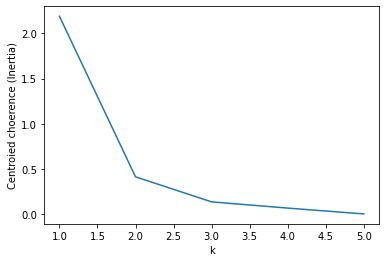

In [103]:
x = np.arange(max_k)+1
plt.plot(x, elbows)
plt.ylabel('Centroied choerence (Inertia)')
plt.xlabel('k')

In [116]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=0).fit(cluster_df)
new_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [117]:
new_df

,Cluster Labels,Campus,Number of students,University,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Columbia,0.650940,1.0,Coffee Shop,American Restaurant,Bookstore,Park,Burger Joint,Café,Deli / Bodega,Greek Restaurant,Paper / Office Supplies Store,Outdoor Sculpture
1,1,EPFL,0.000000,0.0,Hotel,Light Rail Station,Burger Joint,Pizza Place,Deli / Bodega,Food & Drink Shop,Restaurant,Sandwich Place,Science Museum,Café
2,0,Harvard,0.311939,1.0,Café,Bookstore,Pizza Place,Burger Joint,Coffee Shop,American Restaurant,Ice Cream Shop,Gastropub,Plaza,Mexican Restaurant
3,1,MIT,0.002326,0.0,College Gym,Food Truck,Pub,Soccer Field,Concert Hall,College Engineering Building,New American Restaurant,Burrito Place,Pizza Place,Greek Restaurant
4,0,NTNU,1.000000,1.0,Park,Grocery Store,Burger Joint,Gastropub,College Cafeteria,Student Center,Pub,Gym / Fitness Center,Gourmet Shop,Gift Shop
